# Questions

## Increase in surface salinity in the arctic, is there some kind of trend in obersved data? What about models?

## How well does models represent the changes in salinity, and can they be used as a good indication for the future?

## How does sea surface salinity affect the vertical ocean circulation? And is this influence impactfull?

## What can we say about the sea surface salinity in the future, and how will this affect the vertical circulation in the arctic?


In [51]:
import functions as f
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import s3fs
import cftime
import intake
import numpy as np
from joblib import Parallel, delayed
from pyproj import Transformer
from datetime import datetime
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Satellite data

In [19]:
import time
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))
path='escience2022/Antoine/ESA_SMOS_Arctic_Sea_Surface_Salinity/'
sat_files = f.read_satellite_data(num_years=10, path=path)
years = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
start = time.time()
tmp = []
for year in years:
    tmp.append(xr.concat(Parallel(n_jobs=16)(delayed(f.create_xr)(file) for file in sat_files[year]), dim='time'))
print(time.time()-start)

256.5340006351471


In [20]:
sat_data = xr.concat(tmp, dim='time')#, dim='Year')

In [38]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))
path='escience2022/Antoine/ESA_SMOS_Arctic_Sea_Surface_Salinity/'
model_path='escience2022/Ada/daily/'
year = 2015
index = 30*5
sat_files = f.read_satellite_data(num_years=10, path=path)
dat = xr.open_dataset(s3.open(sat_files[year][index])).squeeze()
dat['y'] = dat['y']*1000
dat['x'] = dat['x']*1000
sss = dat['sss']
dat

<xarray.Dataset>
Dimensions:      (y: 432, x: 432)
Coordinates:
    time         datetime64[ns] 2015-06-01T12:08:00
  * y            (y) float32 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
  * x            (x) float32 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
Data variables:
    crs          int32 ...
    sss          (y, x) float32 ...
    sss_error    (y, x) float32 ...
    sss_anomaly  (y, x) float32 ...
    sss_flag     (y, x) float32 ...
Attributes: (12/48)
    title:                     Arctic Sea Surface Salinity L3 map
    institution:               Barcelona Expert Center (BEC), ICM-CSIC, Barce...
    institution_url:           http://bec.icm.csic.es
    summary:                   This dataset contains 9-day Level-3 Arctic sea...
    comment:                   These data were produced at BEC as part of the...
    source:                    SMOS L1B version 6.21
    ...                        ...
    sensor:                    SMOS/MIRAS
    spatial_resolution:        35km at nadir
    license:                   This product is distributed under Creative Com...
    license_url:               https://creativecommons.org/licenses/by/4.0/
    copyright:                 If this data is used for publication, the foll...
    doi:                       10.20350/digitalCSIC/12620

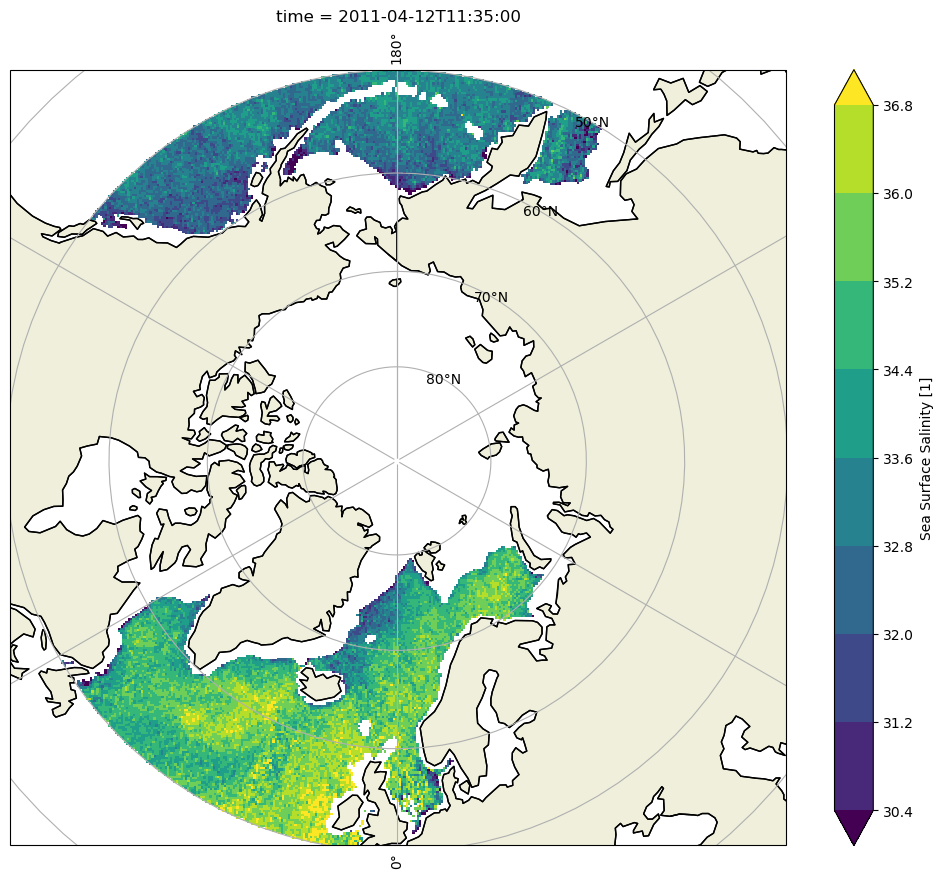

In [44]:
dat = dat.where((dat['lat'] > 70) & (dat['lat'] < 80), drop=True)
#f.plot_sss_sat(dat['sss'], levels=50)

f.plot_sss_sat(sat_data['sss'][100])

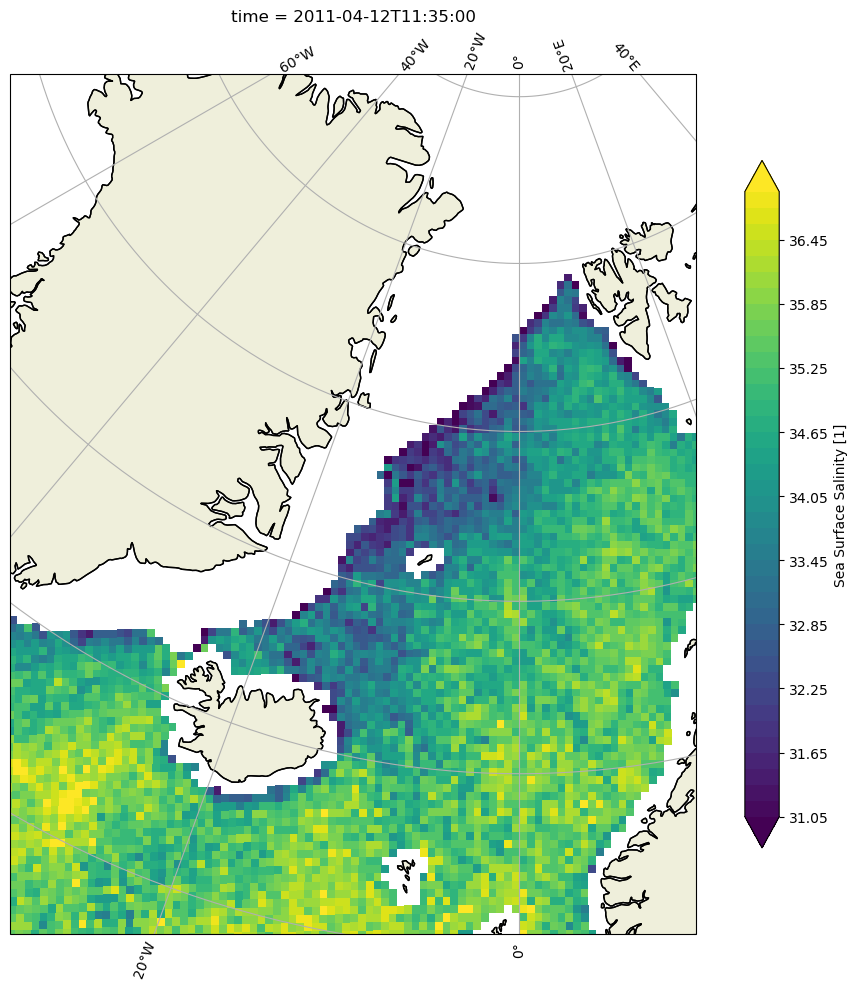

In [22]:
f.plot_sss_sat(sat_data['sss'][100], levels=50, extent=[-30,10,85,60], vmin=10, vmax=40)

In [23]:
sat_data

<xarray.Dataset>
Dimensions:  (time: 3285, y: 432, x: 432)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-02T21:32:30 ... 2019-12-30T12:33:30
  * y        (y) float32 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
  * x        (x) float32 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
    lat      (y, x) float32 16.62 16.82 17.02 17.22 ... 17.22 17.02 16.82 16.62
    lon      (y, x) float32 -45.0 -44.87 -44.73 -44.6 ... 135.3 135.1 135.0
Data variables:
    crs      (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    sss      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/48)
    title:                     Arctic Sea Surface Salinity L3 map
    institution:               Barcelona Expert Center (BEC), ICM-CSIC, Barce...
    institution_url:           http://bec.icm.csic.es
    summary:                   This dataset contains 9-day Level-3 Arctic sea...
    comment:                   These data were produced at BEC as part of the...
    source:                    SMOS L1B version 6.21
    ...                        ...
    sensor:                    SMOS/MIRAS
    spatial_resolution:        35km at nadir
    license:                   This product is distributed under Creative Com...
    license_url:               https://creativecommons.org/licenses/by/4.0/
    copyright:                 If this data is used for publication, the foll...
    doi:                       10.20350/digitalCSIC/12620

In [24]:
sat_data['time']


<xarray.DataArray 'time' (time: 3285)>
array(['2011-01-02T21:32:30.000000000', '2011-01-03T14:56:00.000000000',
       '2011-01-04T11:49:30.000000000', ..., '2019-12-28T12:12:30.000000000',
       '2019-12-29T12:24:30.000000000', '2019-12-30T12:33:30.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2011-01-02T21:32:30 ... 2019-12-30T12:33:30
Attributes:
    standard_name:        time
    long_name:            time
    axis:                 T
    coordinate_defines:   center
    _CoordinateAxisType:  Time

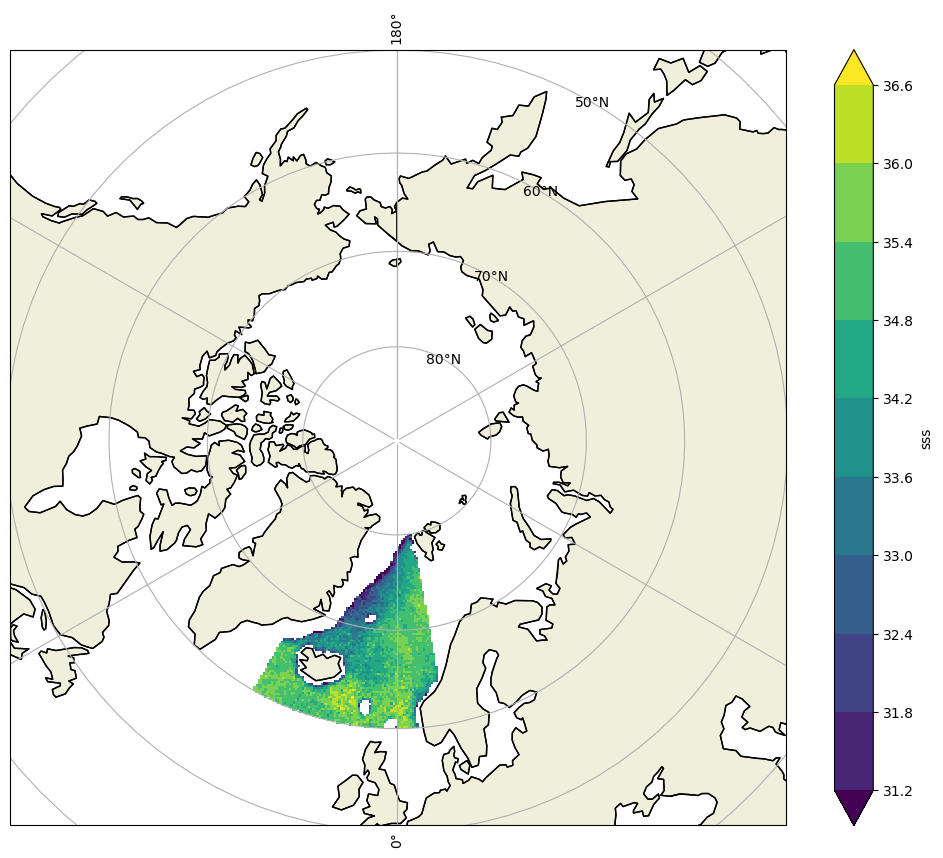

In [85]:
def slicing_data(data, min_time='1950-01-01', max_time='2022-06-01', min_lon=-180, max_lon=180, min_lat=-90, max_lat=90):
    ndata = data.where(
        (data['time'] > np.datetime64(min_time))
        & (data['time'] < np.datetime64(max_time)) 
        & (data['lon'] > min_lon)
        & (data['lon'] < max_lon)
        & (data['lat'] < min_lat)
        & (data['lat'] > max_lat),
        drop=True)
    return ndata
f.plot_sss_sat(sat_data['sss'].mean('time'))

In [84]:
f.plot_sss_sat(sat_data['sss'][100], extent=[-30,10,85,60], levels=50, vmin=10, vmax=40)

IndexError: index 100 is out of bounds for axis 0 with size 27

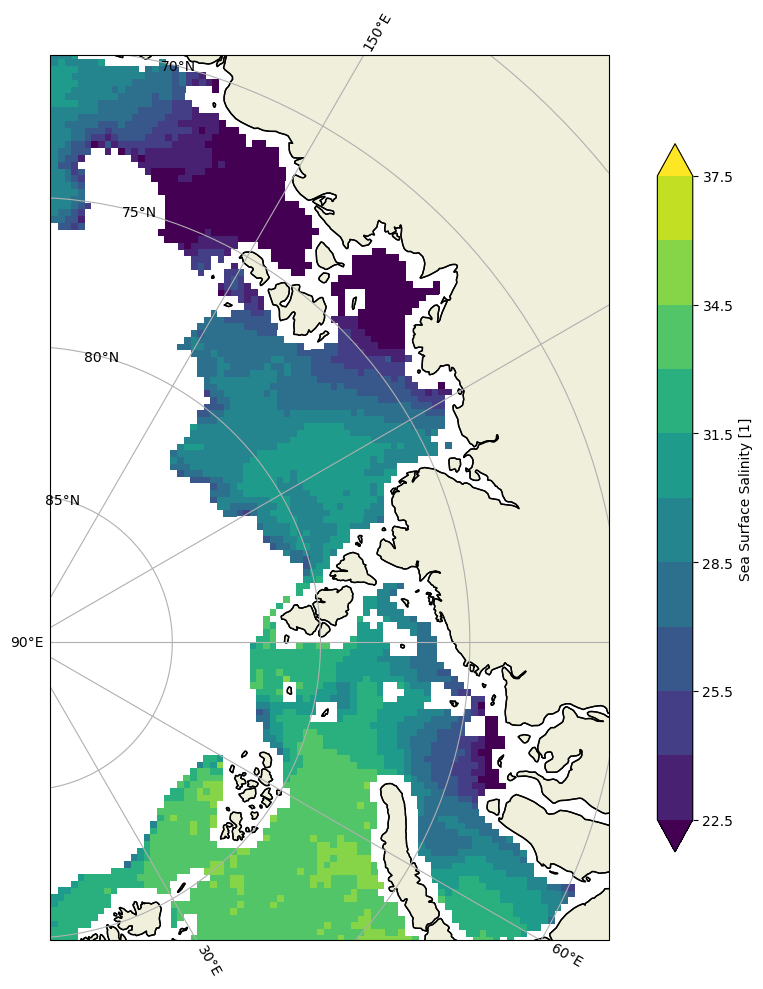

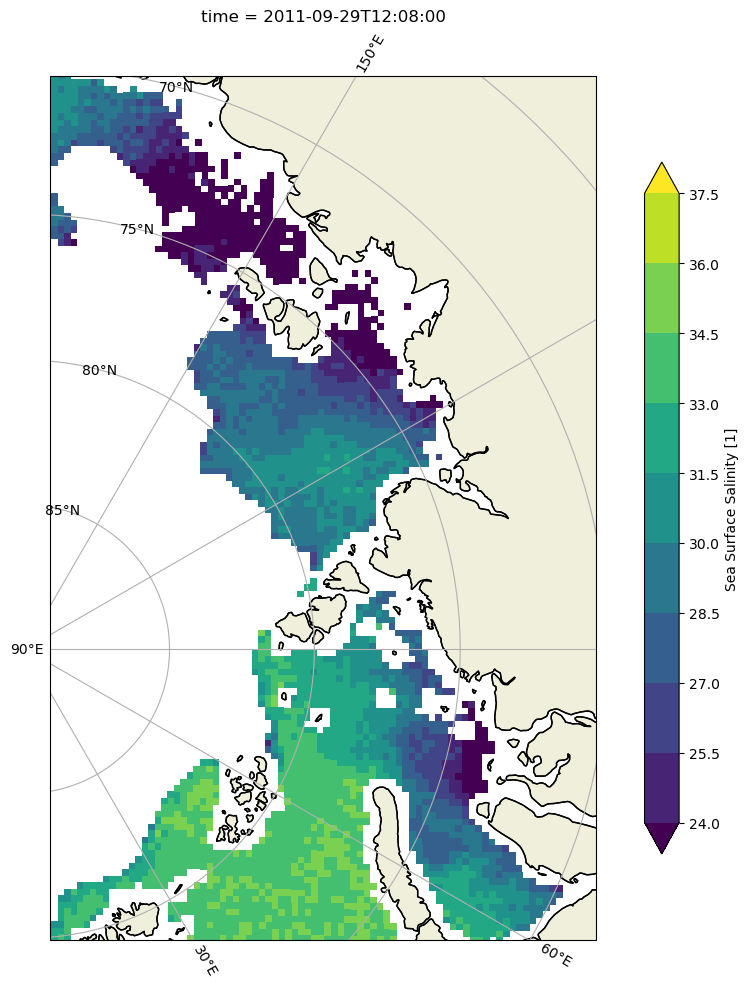

In [66]:
mlen = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

m = sat_data['sss'][250:280].mean('time', keep_attrs=True)
#monthly_mean = data['sss'][mlen[0]:mlen[1]].mean()
#monthly_mean
f.plot_sss_sat(m, extent = [60,170,85,70])
f.plot_sss_sat(sat_data['sss'][270], extent = [60,170,85,70])

In [10]:
mean = m.mean()

## ARGO data

In [67]:
_id = '3901591'
_id2 = '3901620'
argo_path = f's3://escience2022/Ada/ARGO/coriolis/{_id}/{_id}_prof.nc'
argo_path2 = f's3://escience2022/Ada/ARGO/coriolis/{_id2}/{_id2}_prof.nc'

In [68]:
data = xr.open_dataset(s3.open(argo_path))
data2 = xr.open_dataset(s3.open(argo_path2))

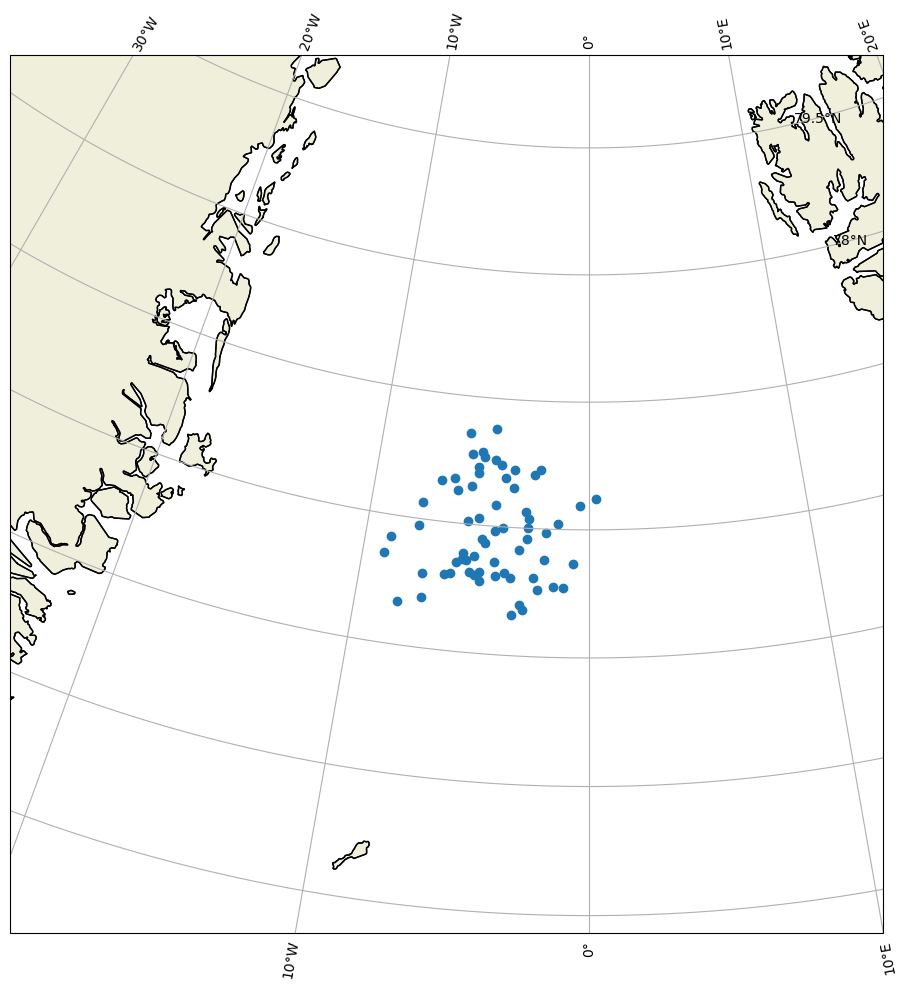

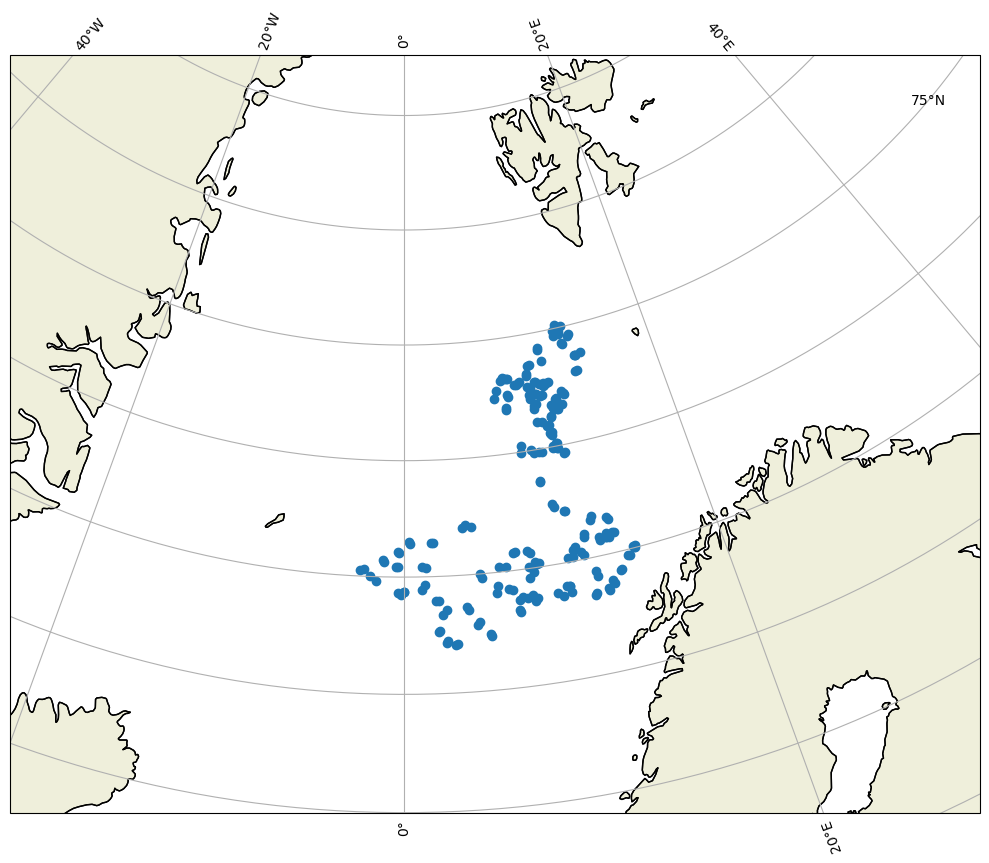

In [69]:
f.plot_argo_positions(data, extent=[-20,10,80,70])
f.plot_argo_positions(data2, extent=[-20,30,80,65])

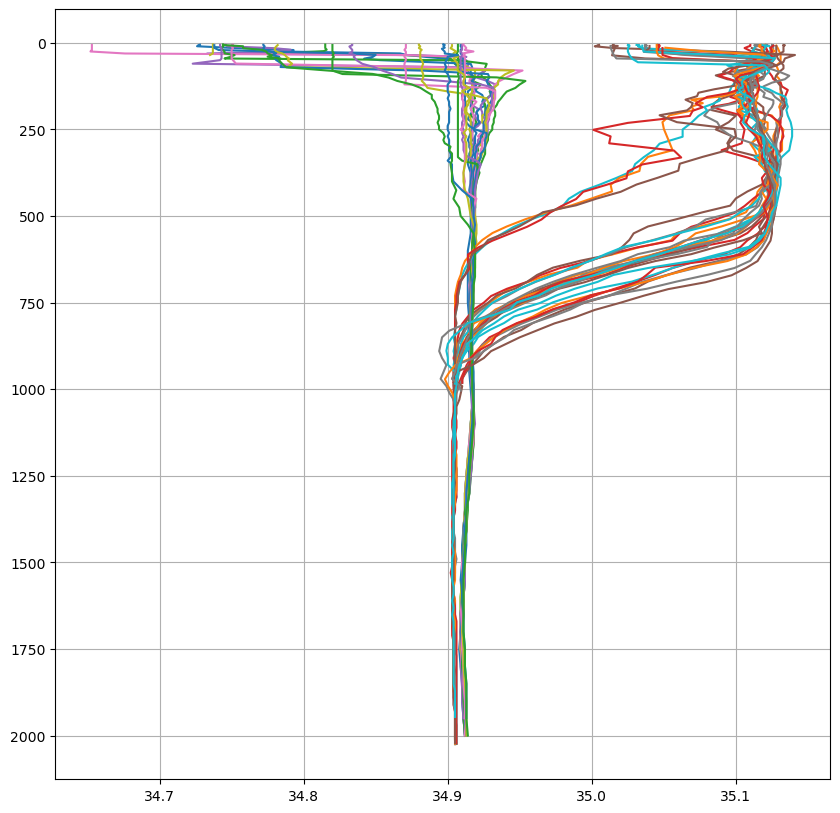

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(30):
    plt.plot(data['PSAL_ADJUSTED'][i], data['PRES'][i])
    plt.plot(data2['PSAL_ADJUSTED'][i], data2['PRES'][i])
plt.gca().invert_yaxis()
ax.grid()

In [71]:
data


<xarray.Dataset>
Dimensions:                       (N_PROF: 65, N_PARAM: 3, N_LEVELS: 80,
                                   N_CALIB: 1)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB
Data variables: (12/52)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    PSAL_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COMMENT      (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_DATE         (N_PROF, N_CALIB, N_PARAM) object ...
Attributes:
    title:                Argo float aggregated multi-cycle profile
    institution:          US GDAC
    source:               Argo float
    history:              2019-07-02T02:00:05Z
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  3.1
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile

## Model data